<a href="https://colab.research.google.com/github/anirudhs123/EE5180-Group-4/blob/main/Music_Instrument_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

In [ ]:
#Importing the required packages and libraries
import os
import librosa
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

!pip install python_speech_features
from python_speech_features import mfcc

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,LSTM,Concatenate,Activation,Input
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras.models import Sequential

!pip install -q tensorflow-model-optimization
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from sklearn.metrics import accuracy_score,classification_report
import tempfile

In [ ]:
%cd /content/drive/My Drive/EEML_data/Instrument_classification_data
#!unzip \*.zip

/content/drive/.shortcut-targets-by-id/1PjT1G82CmVhCm_zwGAqPNoFojg9HS9Oc/EEML_data/Instrument_classification_data


In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
#Getting the counts if each classes in the dataset
#Originally there are 41 classes
df['label'].value_counts()

Snare_drum               300
Hi-hat                   300
Double_bass              300
Fart                     300
Applause                 300
Squeak                   300
Saxophone                300
Bass_drum                300
Tearing                  300
Fireworks                300
Trumpet                  300
Clarinet                 300
Shatter                  300
Flute                    300
Cello                    300
Laughter                 300
Violin_or_fiddle         300
Acoustic_guitar          300
Oboe                     299
Gong                     292
Knock                    279
Writing                  270
Cough                    243
Bark                     239
Tambourine               221
Burping_or_eructation    210
Cowbell                  191
Harmonica                165
Drawer_open_or_close     158
Meow                     155
Electric_piano           150
Gunshot_or_gunfire       147
Microwave_oven           146
Keys_jangling            139
Telephone     

In [ ]:
#Filtering out the Top 5 classes 
#Each class has 300 samples each
df = df[df['label'].isin(['Cello','Saxophone','Acoustic_guitar','Double_bass', 'Clarinet'])]

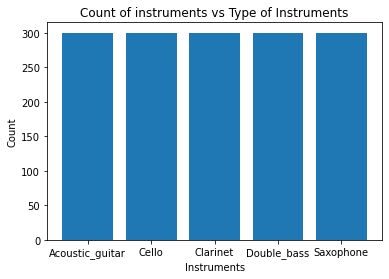

In [ ]:
#Plot to show the distribution of classes individually
plt.bar(np.unique(df['label'].values),df['label'].value_counts())
plt.ylabel('Count')
plt.xlabel('Instruments')
plt.title('Count of instruments vs Type of Instruments')
plt.show()

In [ ]:
#Collecting the Audio data from the .wav files
#Librosa is used to directly load the .wav file into numy array format
path = 'audio_train/'
audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(path+df['fname'].iloc[i]))
audio_data = np.array(audio_data)

100%|██████████| 1500/1500 [17:41<00:00,  1.41it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
#The audio data and corresponding Sample frequency is stored in the dataframe
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]

In [ ]:
#Bit lengths - Length of the sampled audio data 
#Second length- Length if the audio ins Seconds
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['seconds_length'] = df['bit_lengths']/df['samplerate']

In [ ]:
#Outlier Removal-I
#We remove the parts of data with length of audio < 2 seconds
#This is reasoned out because it is difficult for a model to learn/identify without sufficient second lengths
df = df[df['seconds_length'] >= 2.0]

In [ ]:
#df['seconds_length'].max()
#Identifying the Minnimum of length of Bits and Length in seconds of the audio data 
min_bits = np.min(df['bit_lengths'])
print('Minimum Bit Length: {}'.format(min_bits))

min_seconds = np.min(df['seconds_length'])
print('Minimum Seconds length: {}'.format(min_seconds))

Minimum Bit Length: 44100
Minimum Seconds length: 2.0


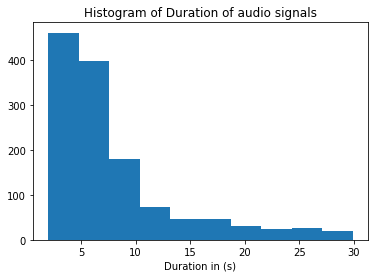

In [ ]:
plt.hist(df['seconds_length'])
plt.title('Histogram of Duration of audio signals')
plt.xlabel('Duration in (s)')
#plt.grid()
plt.show()

# Data Preprocessing

In [ ]:
#Fenerating audio waves and setting up correspnding labels
#Num samples to be generated is a hyper parameter

num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df['fname'].values)
        chosen_initial = np.random.choice(np.arange(0,df[df['fname']==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df['fname']==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])
        
        generated_audio_labels.append(df[df['fname']==chosen_file]['label'].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 6000/6000 [00:10<00:00, 555.64it/s]


In [ ]:
#Converting the label names into Integers
# ['Cello','Saxophone','Acoustic_guitar','Double_bass', 'Clarinet'] is converted into intergers from 0-4
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)

label_encoded = label_encoded[:, np.newaxis]

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Converting the labels into one hot encoded form
#This converts each label from its integer represntation to 1*5 vector form
# Label 3 becomes - [0,0,0,1,0]
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)

In [ ]:
# with open('audio_df.pickle', 'rb') as f:
#     df = pickle.load(f)

In [ ]:
#Generating the MFCC features from the generated Audio waves data
#We make use of the Python_speech_ features for conversion
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 5976/5976 [00:45<00:00, 130.14it/s]


In [ ]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(5976, 44100)
(5976, 275, 13)


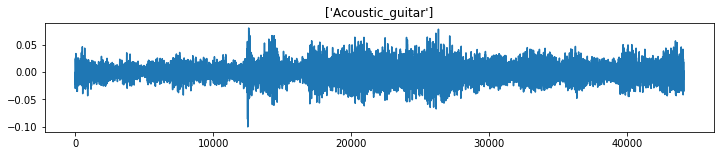

In [ ]:
# Sample Plot of generated Audiowave data
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[2])
plt.title(generated_audio_labels[2])
plt.show()

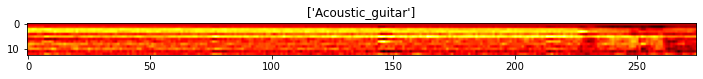

In [ ]:
#Sample plot of corresponding MFCC feature plot
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[0].T, cmap='hot')
plt.title(generated_audio_labels[0])
plt.show()

In [ ]:
#Forming the dependent and independent variables for model creation
#X is the input to the model
#y is expected output (Ground truth values) 
X = mfcc_features
y = one_hot_encoded

In [ ]:
#Data scaling
#Using Range scaling operation
#This converts the input array values between [0,1]
X = (X-X.min())/(X.max()-X.min())

In [ ]:
#Splitting the data into train and test sets
#Train- 0.8, Test -0.2
#Random state is fixed to replicate the split in the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
#Shape of the input data into the CNN model
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
#print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
#print(X_test.shape)

# CNN Model

In [ ]:
#Building a CNN model with two Conv layers and three Dense layers
# Optimal Parameters for each of these layers are obtained from Keras-Tuner

model = Sequential()
model.add(Conv2D(40, (1, 1), activation='relu', strides=(1, 1),padding='same', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Conv2D(32, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(16, (1, 1), activation='relu', strides=(1, 1), padding='same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['accuracy'])

In [ ]:
#Training the data for 30 epochs
#Using Model checkpoints to avoid overfitting
#Using a validation split of 0.2 from the train data

checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history=model.fit(X_train,y_train,epochs=30,batch_size=16,
          callbacks=[model_checkpoint_callback],
          validation_split=0.2)

model.load_weights(checkpoint_filepath)

In [ ]:
#Ploting the variation in Train and Validation loss vs Epochs
#Ploting the variation in Train and Validation accuracy vs Epochs

plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()

plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

print('Train accuracy at the end of 30 epochs:', history.history['accuracy'][-1])
print('val_accuracy at the end of 30 epochs:', history.history['val_accuracy'][-1])


In [ ]:
#Making predictions on the test set for the trtained model
predictions = model.predict(X_test)
#Identifying the class with highest probability of prediction
predictions = np.argmax(predictions, axis=1)

#Converting the 1*5 vectors back into interger form
y_test_1 = one_hot_encoder.inverse_transform(y_test)

In [ ]:
print('Accuracy of CNN model {}'.format(accuracy_score(y_test_1,predictions)))

Accuracy of CNN model 0.7978187919463087


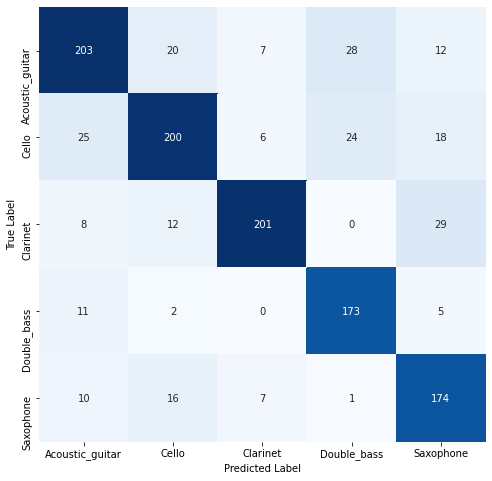

In [ ]:
#Printing the Confusion matrox to visualize the model predictions
#Confusion matrix gives us an idea about the model capabilities
cm = confusion_matrix(y_test_1, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Cut Mix algorithm

In [ ]:
#Generation of random subspace within the input 2D array
def rand_bbox(size, lamb):
    """ Generate random subspace 
    Args:
        - size: width,height of the subspace
        - lamb: (lambda) cut ratio parameter
    Returns:
        - Bounding interval
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)
    

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    
    return bbx1, bby1, bbx2, bby2

In [ ]:
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    # generate mixed sample
    #We sample out the lambda parameter from a Beta distribution
    lam = np.random.beta(beta, beta)
    #We choose a random audio element to make perturbations with
    rand_index = np.random.permutation(len(image_batch))
    #Taget a - Label of original audio
    #Target b- Label of Randomly picked audio
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    #We obtain the region to perturbed in the original audio
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)

    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]
   
    # adjusting lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return image_batch_updated, label

In [ ]:
def gendata(X_train,y_train,beta=1):
  X_aug,y_aug=generate_cutmix_image(X_train,y_train,beta)
  return(X_aug,y_aug)

In [ ]:
#Betas is a hyperparameter list
#We sample out different betas to get different lambdas and different perturbed audio signals
betas=[1,0.9,0.8]
i=0
for beta in betas:
  X_train1,y_train1=gendata(X_train,y_train,beta)
  if(i==0):
    Xs=X_train1
    ys=y_train1
    i+=1
  else:  
    Xs=np.vstack([Xs,X_train1])
    ys=np.vstack([ys,y_train1])

In [ ]:
#Augmenting the perturbed audio signals with the oroginal train data
#This helps us increase the available train data by 3 folds
X_train=np.vstack([X_train,Xs])
y_train=np.vstack([y_train,ys])

In [ ]:
X_train.shape, y_train.shape

((19120, 275, 13, 1), (19120, 5))

# CNN model with Cut Mix

In [ ]:
#Building CNN model

model_cutmix = Sequential()
model_cutmix .add(Conv2D(40, (1, 1), activation='relu', input_shape=input_shape))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Conv2D(32, (5, 5), activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Conv2D(16, (1, 1), activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Flatten())
model_cutmix .add(Dense(64, activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Dense(16, activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Dense(12, activation='relu'))
model_cutmix .add(Dropout(0.1))
model_cutmix .add(Dense(5, activation='softmax'))

model_cutmix .compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['accuracy'])

In [ ]:
#Training the data for 50 epochs
#Using Model checkpoints to avoid overfitting
#Using a validation split of 0.2 from the train data

checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_cutmix =model_cutmix .fit(X_train,y_train,epochs=50,batch_size=32,
          callbacks=[model_checkpoint_callback],
          #validation_split=0.2
          validation_data=(X_test,y_test))

model_cutmix .load_weights(checkpoint_filepath)

loss: 0.48519957065582275
val_loss: 0.5782576203346252


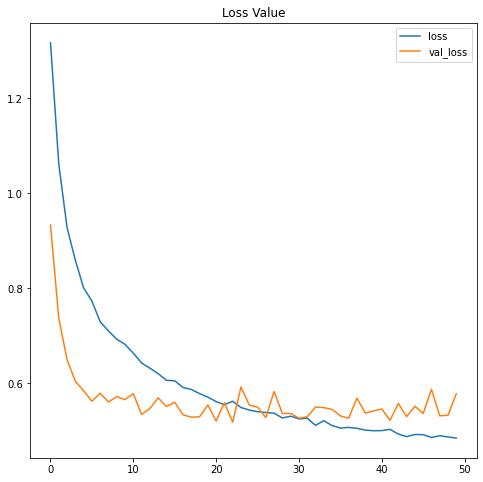

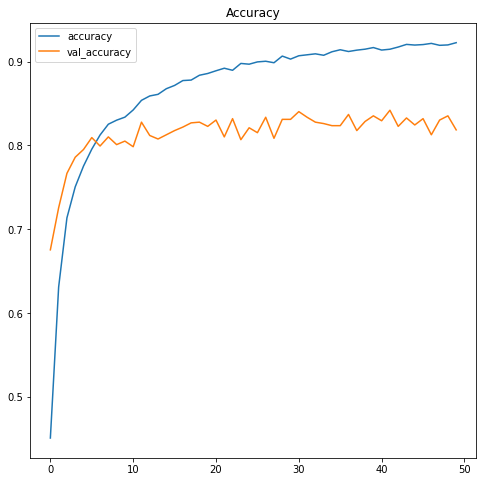

Train accuracy at the end of 50 epochs: 0.9224895238876343
val_accuracy at the end of 50 epochs: 0.818561851978302


In [ ]:
#Ploting the variation in Train and Validation loss vs Epochs
#Ploting the variation in Train and Validation accuracy vs Epochs

plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history_cutmix .history['loss'])
plt.plot(history_cutmix .history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history_cutmix .history['loss'][-1])
print('val_loss:', history_cutmix .history['val_loss'][-1])
plt.show()

plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history_cutmix .history['accuracy'])
plt.plot(history_cutmix .history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

print('Train accuracy at the end of 50 epochs:', history_cutmix .history['accuracy'][-1])
print('val_accuracy at the end of 50 epochs:', history_cutmix .history['val_accuracy'][-1])


In [ ]:
#Defining function for determining Model performance for DL models
def model_performance_DL(model,X_train,y_train,X_test,y_test,y_test_1):
  #Model is fit on the train set and then used to predict ono Test set
  y_pred = model.predict(X_test)
  predicted=[]
  predicted_prob=y_pred
  for i in range(len(y_pred)):
    predicted.append(np.argmax(y_pred[i]))
    
  
  #Different metrics are used to check the model performance
  #Weighted precision,recall,f1_score is reported for all models
  classes = np.unique(y_test_1)
  #y_test_array = pd.get_dummies(y_test, drop_first=False).values
  y_test_array=y_test_1

  accuracy = accuracy_score(y_test_1, predicted)
  print("Accuracy:",  round(accuracy,2))
  #print("Auc:", round(auc,2))
  print("Detail:")
  print(classification_report(y_test_1, predicted))

  ## Plot confusion matrix
  cm = confusion_matrix(y_test_1, predicted)
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  sns.heatmap(cmn, annot=True, fmt='.2f', ax=ax, cmap='YlGnBu', 
            )
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)
  

Accuracy: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       258
           1       0.84      0.80      0.82       281
           2       0.90      0.85      0.88       253
           3       0.84      0.89      0.86       166
           4       0.81      0.87      0.84       238

    accuracy                           0.84      1196
   macro avg       0.84      0.85      0.84      1196
weighted avg       0.84      0.84      0.84      1196



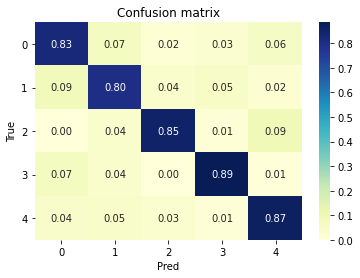

In [ ]:
model_performance_DL(model_cutmix,X_train,y_train,X_test,y_test,y_test_1)

In [ ]:
#Making predictions on the test set for the trtained model
predictions = model_cutmix.predict(X_test)
#Identifying the class with highest probability of prediction
predictions = np.argmax(predictions, axis=1)

#Converting the 1*5 vectors back into interger form
y_test_1 = one_hot_encoder.inverse_transform(y_test)

In [ ]:
print('Accuracy Cut-Mix {}'.format(accuracy_score(y_test_1,predictions)))

Accuracy Cut-Mix 0.8419732441471572


In [ ]:
print(classification_report(y_test_1,predictions))

              precision    recall  f1-score   support

           0       0.82      0.83      0.82       258
           1       0.84      0.80      0.82       281
           2       0.90      0.85      0.88       253
           3       0.84      0.89      0.86       166
           4       0.81      0.87      0.84       238

    accuracy                           0.84      1196
   macro avg       0.84      0.85      0.84      1196
weighted avg       0.84      0.84      0.84      1196



In [ ]:
#model_cutmix.save_weights('/content/best_weights_MIC_CNN_CUTMIX.h5')
#model_cutmix.load_weights("/content/best_weights_MIC_CNN_CUTMIX.h5")

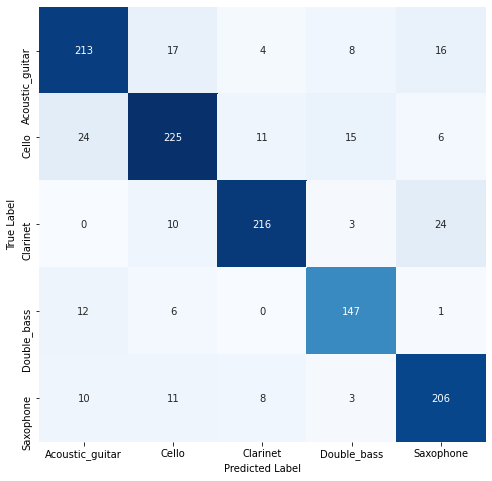

In [ ]:
#Printing the Confusion matrox to visualize the model predictions
#Confusion matrix gives us an idea about the model capabilities

cm = confusion_matrix(y_test_1, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Pruning 

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 16
epochs = 30
validation_split = 0.2 # 20% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model_cutmix, **pruning_params)

# prune_low_magnitude requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
model_cutmix.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 275, 13, 40)       400       
_________________________________________________________________
dropout_12 (Dropout)         (None, 275, 13, 40)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 275, 13, 32)       1312      
_________________________________________________________________
dropout_13 (Dropout)         (None, 275, 13, 32)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 275, 13, 16)       528       
_________________________________________________________________
dropout_14 (Dropout)         (None, 275, 13, 16)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57200)            

In [ ]:
import tempfile
logdir = tempfile.mkdtemp()
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]
model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

In [ ]:
#Making predictions on the test set for the trtained model
predictions=model_for_pruning.predict(X_test)
#Identifying the class with highest probability of prediction
predictions = np.argmax(predictions, axis=1)
#Converting the 1*5 vectors back into interger form
y_test_1 = one_hot_encoder.inverse_transform(y_test)

In [ ]:
print('Accuracy Pruned Model {}'.format(accuracy_score(y_test_1,predictions)))

Accuracy Pruned Model 0.7986577181208053


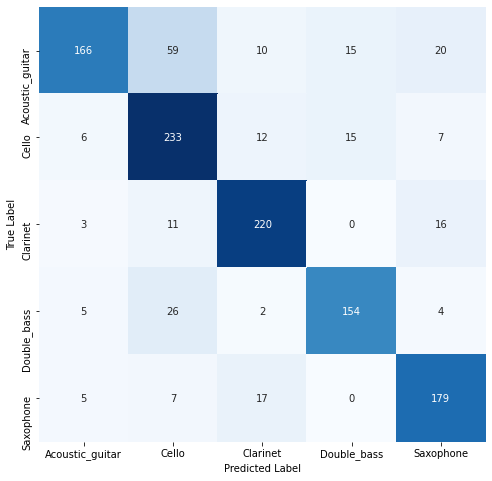

In [ ]:
#Printing the Confusion matrox to visualize the model predictions
#Confusion matrix gives us an idea about the model capabilities

cm = confusion_matrix(y_test_1, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_test_1,predictions))

              precision    recall  f1-score   support

           0       0.90      0.61      0.73       270
           1       0.69      0.85      0.77       273
           2       0.84      0.88      0.86       250
           3       0.84      0.81      0.82       191
           4       0.79      0.86      0.82       208

    accuracy                           0.80      1192
   macro avg       0.81      0.80      0.80      1192
weighted avg       0.81      0.80      0.80      1192



In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(X_test, y_test, verbose=0)
_, model_accuracy = model.evaluate(X_test, y_test, verbose=0)
_, model_cutmix_accuracy = model_cutmix.evaluate(X_test, y_test, verbose=0)

print('Baseline Model test accuracy:', model_accuracy)
print('Cut-Mix Model test accuracy:', model_cutmix_accuracy)
print('Pruned test accuracy:', model_for_pruning_accuracy)

Baseline Model test accuracy: 0.7978187799453735
Cut-Mix Model test accuracy: 0.7986577153205872
Pruned test accuracy: 0.7986577153205872


# Class Activation Maps 

In [ ]:
x=np.reshape(X_test[10],(1,X_test[0].shape[0],X_test[0].shape[1],X_test[0].shape[2]))

In [ ]:
def make_gradcam_heatmap(img_array, model):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.layers[5]
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
    
    # Mark the classifying layers
    classifier_layers = model.layers[-8:]

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for classifier_layer in classifier_layers:
        x = classifier_layer(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

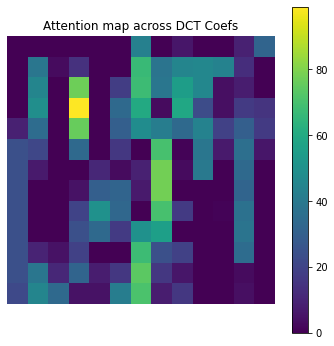

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
plt.figure(figsize=(6,6))
for n in range(1):
    #ax = plt.subplot(1,1,n+1)
    #heatmap = make_gradcam_heatmap(x, model_for_pruning)
    heatmap = make_gradcam_heatmap(x, model_cutmix)
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    pred=np.argmax(model.predict(x))
    #plt.imshow(np.matmul(heatmap.T,heatmap))
    plt.imshow(heatmap[:13,:])
    plt.title('Attention map across DCT Coefs')
    plt.colorbar()
    plt.xlabel('Head')
    plt.ylabel('Layer')
    plt.axis("off")


# Comparative Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
#Splitting the data into train and test sets
#Train- 0.8, Test -0.2
#Random state is fixed to replicate the split in the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score

In [ ]:
Y_train=one_hot_encoder.inverse_transform(y_train)
Y_test=one_hot_encoder.inverse_transform(y_test)

In [ ]:
x_train=np.reshape(X_train,(X_train.shape[0],-1))
x_test=np.reshape(X_test,(X_test.shape[0],-1))

In [ ]:
#Logistic Regression
model=LogisticRegression(max_iter=300)
model.fit(x_train,Y_train)
y_pred=model.predict(x_test)

print('Accuracy of Logistic Reg : {:.2f}'.format(accuracy_score(Y_test,y_pred)))
print(classification_report(Y_test,y_pred))

Accuracy of Logistic Reg : 0.68
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       270
           1       0.77      0.63      0.69       273
           2       0.67      0.71      0.69       250
           3       0.67      0.81      0.73       191
           4       0.60      0.66      0.63       208

    accuracy                           0.68      1192
   macro avg       0.68      0.68      0.68      1192
weighted avg       0.68      0.68      0.68      1192



In [ ]:
#NB
model=GaussianNB()
model.fit(x_train,Y_train)
y_pred=model.predict(x_test)

print('Accuracy of Naive Bayes Clf : {:.2f}'.format(accuracy_score(Y_test,y_pred)))
print(classification_report(Y_test,y_pred))

Accuracy of Naive Bayes Reg : 0.58
              precision    recall  f1-score   support

           0       0.69      0.37      0.48       270
           1       0.63      0.46      0.53       273
           2       0.75      0.67      0.71       250
           3       0.49      0.76      0.60       191
           4       0.45      0.71      0.55       208

    accuracy                           0.58      1192
   macro avg       0.60      0.60      0.58      1192
weighted avg       0.62      0.58      0.57      1192



In [ ]:
#SVM 
model=SVC(kernel='linear')
model.fit(x_train,Y_train)
y_pred=model.predict(x_test)

print('Accuracy of SVM Clf: {:.2f}'.format(accuracy_score(Y_test,y_pred)))
print(classification_report(Y_test,y_pred))

Accuracy of SVM Clf: 0.71
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       270
           1       0.77      0.67      0.71       273
           2       0.72      0.69      0.70       250
           3       0.74      0.82      0.78       191
           4       0.63      0.66      0.64       208

    accuracy                           0.71      1192
   macro avg       0.71      0.71      0.71      1192
weighted avg       0.71      0.71      0.71      1192



In [ ]:
#DT Clf
model=DecisionTreeClassifier()
model.fit(x_train,Y_train)
y_pred=model.predict(x_test)

print('Accuracy of Decision Tree Clf: {:.2f}'.format(accuracy_score(Y_test,y_pred)))
print(classification_report(Y_test,y_pred))

Accuracy of Decision Tree Clf: 0.64
              precision    recall  f1-score   support

           0       0.62      0.65      0.63       270
           1       0.63      0.64      0.64       273
           2       0.71      0.65      0.68       250
           3       0.65      0.61      0.63       191
           4       0.58      0.63      0.61       208

    accuracy                           0.64      1192
   macro avg       0.64      0.63      0.64      1192
weighted avg       0.64      0.64      0.64      1192



In [ ]:
#Random Forest
model=RandomForestClassifier(n_estimators=50)
model.fit(x_train,Y_train)
y_pred=model.predict(x_test)

print('Accuracy of RF Clf: {:.2f}'.format(accuracy_score(Y_test,y_pred)))
print(classification_report(Y_test,y_pred))

Accuracy of SVM Clf: 0.82
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       270
           1       0.82      0.80      0.81       273
           2       0.84      0.89      0.87       250
           3       0.85      0.85      0.85       191
           4       0.80      0.80      0.80       208

    accuracy                           0.82      1192
   macro avg       0.82      0.83      0.82      1192
weighted avg       0.82      0.82      0.82      1192



In [ ]:
# Adaboost
model=AdaBoostClassifier(n_estimators=100)
model.fit(x_train,Y_train)
y_pred=model.predict(x_test)

print('Accuracy of Adaboost Clf: {:.2f}'.format(accuracy_score(Y_test,y_pred)))
print(classification_report(Y_test,y_pred))

Accuracy of Adaboost Clf: 0.62
              precision    recall  f1-score   support

           0       0.54      0.44      0.48       270
           1       0.66      0.69      0.68       273
           2       0.73      0.71      0.72       250
           3       0.58      0.68      0.63       191
           4       0.59      0.63      0.61       208

    accuracy                           0.62      1192
   macro avg       0.62      0.63      0.62      1192
weighted avg       0.62      0.62      0.62      1192



# Hyperparameter Tuning

In [ ]:
! pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras

#Building model
from keras.layers import Dense,LeakyReLU,ELU,PReLU,Dropout,Conv2D
from keras.models import Sequential

In [ ]:
def  build_model(hp):
  model=keras.Sequential([
                          keras.layers.Conv2D(filters=hp.Int('Conv_1_filter',min_value=16,max_value=32,step=8),
                                              kernel_size=hp.Choice('Convo_1_kernels',values=[1,3,5]),
                                              activation='relu',
                                              input_shape=input_shape),
                           keras.layers.Dropout(0.2),
                           keras.layers.Conv2D(filters=hp.Int('Conv_2_filter',min_value=8,max_value=16,step=4),
                                              kernel_size=hp.Choice('Convo_2_kernels',values=[1,3,5]),
                                              activation='relu'),
                           keras.layers.Dropout(0.2),
                           keras.layers.Conv2D(filters=hp.Int('Conv_3_filter',min_value=4,max_value=8,step=2),
                                              kernel_size=hp.Choice('Convo_3_kernels',values=[1,3,5]),
                                              activation='relu'),
                          keras.layers.Dropout(0.2),
                          keras.layers.Flatten(),
                          keras.layers.Dense(units=hp.Int('Dense_1_units',min_value=16,max_value=32,step=8),
                                             activation='relu'
                                             ),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(units=hp.Int('Dense_2_units',min_value=8,max_value=16,step=4),
                                             activation='relu'
                                             ),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(units=hp.Int('Dense_3_units',min_value=4,max_value=8,step=2),
                                             activation='relu'
                                             ),
                          keras.layers.Dropout(0.1),
                          keras.layers.Dense(units=5,activation='softmax')
                          
                                             ])
  model .compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  return(model)

from kerastuner import RandomSearch
import kerastuner.engine.hyperparameters as Hyperparameters

tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=10
                          )
tuner_search.search(X_train,y_train,epochs=10,validation_split=0.1)
model=tuner_search.get_best_models(num_models=1)[0]
model.summary()
model.fit(X_train,y_train,epochs=50,validation_split=0.2,initial_epoch=10)

preds_y=model.predict(X_test)

In [ ]:
#Making predictions on the test set for the trtained model
predictions = model.predict(X_test)
#Identifying the class with highest probability of prediction
predictions = np.argmax(predictions, axis=1)

#Converting the 1*5 vectors back into interger form
y_test_1 = one_hot_encoder.inverse_transform(y_test)

In [ ]:
print('Accuracy of CNN model {}'.format(accuracy_score(y_test_1,predictions)))

Accuracy of CNN model 0.8352842809364549


# Ablation study

In [ ]:
#Building CNN model
#Commenting out unwanted columns to note down the results only with required layers

model_cutmix = Sequential()
# model_cutmix .add(Conv2D(40, (3, 3), activation='relu', strides=(1, 1),padding='same', input_shape=input_shape))
# model_cutmix .add(Dropout(0.2))
# model_cutmix .add(Conv2D(32, (1, 1), activation='relu', strides=(1, 1),padding='same'))
# model_cutmix .add(Dropout(0.2))
# model_cutmix .add(Conv2D(16, (1, 1), activation='relu', strides=(1, 1),padding='same'))
# model_cutmix .add(Dropout(0.2))
# model_cutmix .add(Flatten())
model_cutmix .add(Dense(64, activation='relu',input_shape=(3575,)))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Dense(16, activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Dense(12, activation='relu'))
model_cutmix .add(Dropout(0.1))
model_cutmix .add(Dense(5, activation='softmax'))

model_cutmix .compile(loss='categorical_crossentropy', 
     optimizer='adam',
     metrics=['accuracy'])

In [ ]:
#Training the data for 50 epochs
#Using Model checkpoints to avoid overfitting
#Using a validation split of 0.2 from the train data

checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_cutmix =model_cutmix .fit(np.reshape(X_train,(X_train.shape[0],-1)),y_train,epochs=50,batch_size=32,
          callbacks=[model_checkpoint_callback],
          #validation_split=0.2
          validation_data=(np.reshape(X_test,(X_test.shape[0],-1)),y_test))

model_cutmix .load_weights(checkpoint_filepath)

Epoch 1/50
598/598 [==============================] - 3s 4ms/step - loss: 1.5951 - accuracy: 0.2568 - val_loss: 1.4029 - val_accuracy: 0.3186
Epoch 2/50
598/598 [==============================] - 2s 3ms/step - loss: 1.4739 - accuracy: 0.3203 - val_loss: 1.3299 - val_accuracy: 0.3746
Epoch 3/50
598/598 [==============================] - 2s 3ms/step - loss: 1.4515 - accuracy: 0.3429 - val_loss: 1.3788 - val_accuracy: 0.3612
Epoch 4/50
598/598 [==============================] - 2s 3ms/step - loss: 1.4288 - accuracy: 0.3525 - val_loss: 1.3064 - val_accuracy: 0.4197
Epoch 5/50
598/598 [==============================] - 2s 3ms/step - loss: 1.4233 - accuracy: 0.3576 - val_loss: 1.3721 - val_accuracy: 0.3620
Epoch 6/50
598/598 [==============================] - 2s 3ms/step - loss: 1.4319 - accuracy: 0.3508 - val_loss: 1.3335 - val_accuracy: 0.3896
Epoch 7/50
598/598 [==============================] - 2s 3ms/step - loss: 1.4244 - accuracy: 0.3552 - val_loss: 1.2996 - val_accuracy: 0.4331
Epoch 

In [ ]:
#np.reshape(X_train,(X_train.shape[0],-1))

In [ ]:
#Making predictions on the test set for the trtained model
#predictions = model_cutmix.predict(X_test)
predictions = model_cutmix.predict(np.reshape(X_test,(X_test.shape[0],-1)))
#Identifying the class with highest probability of prediction
predictions = np.argmax(predictions, axis=1)

#Converting the 1*5 vectors back into interger form
y_test_1 = one_hot_encoder.inverse_transform(y_test)

In [ ]:
print('Accuracy of CNN model {}'.format(accuracy_score(y_test_1,predictions)))